In [1]:
import matplotlib.pyplot as plt
import cv2
from visualizer.kitti_object import kitti_object, show_lidar_with_depth, show_lidar_on_image, \
                         show_image_with_boxes, show_lidar_topview_with_boxes
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = kitti_object(r'D:\Workspace\Python\Data', 'training')

data_idx = 100
objects = dataset.get_label_objects(data_idx)
pc_velo = dataset.get_lidar(data_idx)
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape





D:\Workspace\Python\Data training
D:\Workspace\Python\Data\training\velodyne\000100.bin


In [3]:
print("Số điểm point cloud:", pc_velo.shape)

Số điểm point cloud: (123183, 4)


In [4]:
import numpy as np

pc_velo = pc_velo[np.random.choice(pc_velo.shape[0], 10000, replace=False)]


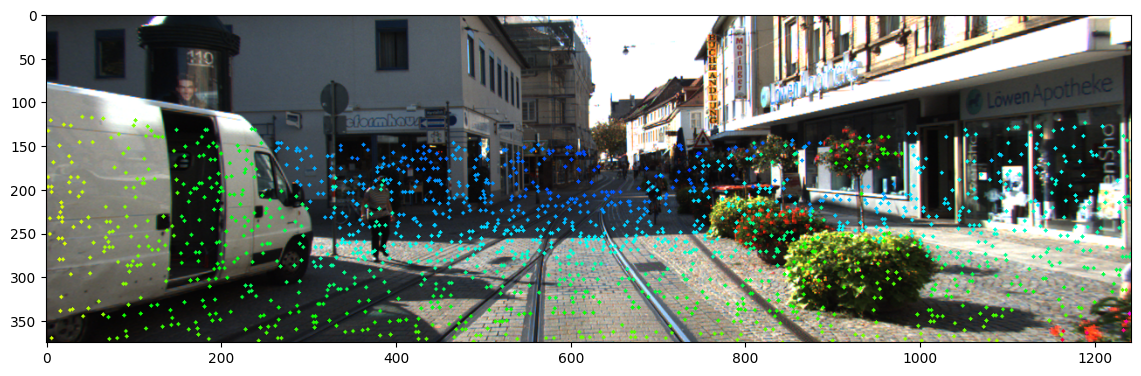

In [5]:
img_lidar = show_lidar_on_image(pc_velo[:, :3], img, calib, img_width, img_height)
img_lidar = cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB)

fig_lidar = plt.figure(figsize=(14, 7))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.show()

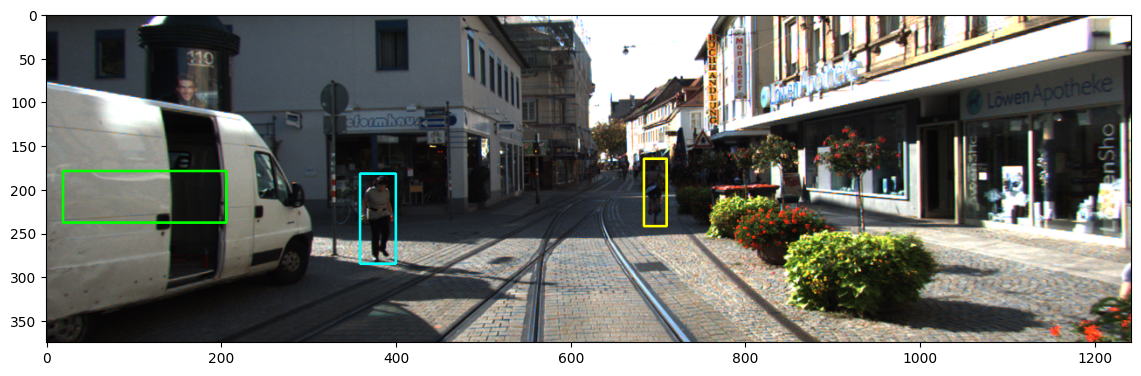

In [6]:
img_bbox2d, img_bbox3d = show_image_with_boxes(img, objects, calib)
img_bbox2d = cv2.cvtColor(img_bbox2d, cv2.COLOR_BGR2RGB)

fig_bbox2d = plt.figure(figsize=(14, 7))
ax_bbox2d = fig_bbox2d.subplots()
ax_bbox2d.imshow(img_bbox2d)
plt.show()

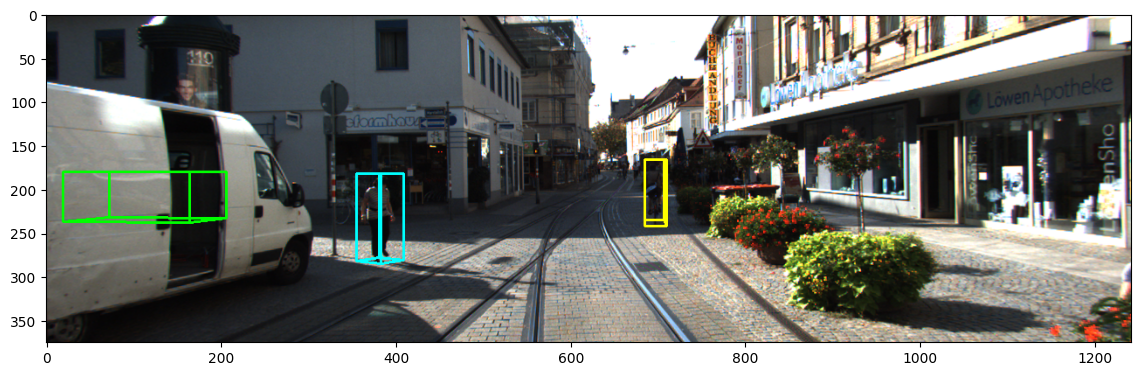

In [7]:
img_bbox3d = cv2.cvtColor(img_bbox3d, cv2.COLOR_BGR2RGB)

fig_bbox3d = plt.figure(figsize=(14, 7))
ax_bbox3d = fig_bbox3d.subplots()
ax_bbox3d.imshow(img_bbox3d)
plt.show()

top_image: (500, 300, 3)


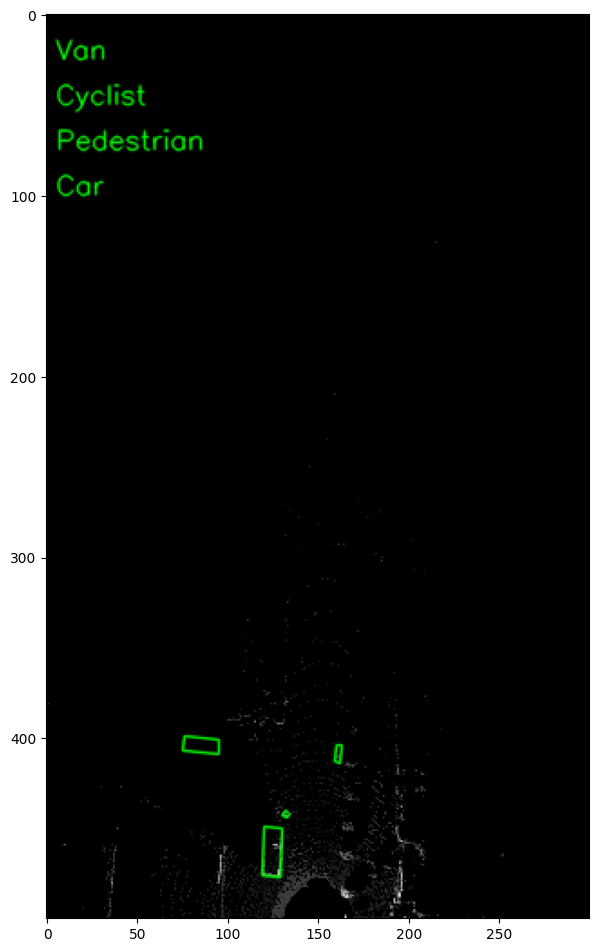

In [8]:
img_bev = show_lidar_topview_with_boxes(pc_velo, objects, calib)

fig_bev = plt.figure(figsize=(7, 14))
ax_bev = fig_bev.subplots()
ax_bev.imshow(img_bev)
plt.show()

In [38]:
dataset = kitti_object(r'D:\Workspace\Python\Data', 'testing')

data_idx = 100

pc_velo = dataset.get_lidar(data_idx)
pc_velo = pc_velo[np.random.choice(pc_velo.shape[0], 10000, replace=False)]
pc_velo = pc_velo[:, :3]
calib = dataset.get_calibration(data_idx)
img = dataset.get_image(data_idx)
img_height, img_width, _ = img.shape

D:\Workspace\Python\Data testing
D:\Workspace\Python\Data\testing\velodyne\000100.bin


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# helper functions:
def farthest_point_sample(xyz, npoint):
    batch_size, n, _ = xyz.shape
    device = xyz.device
    centroids = torch.zeros(batch_size, npoint, dtype=torch.long).to(device)
    distance = torch.ones(batch_size, n).to(device) * 1e10
    farthest = torch.randint(0, n, (batch_size,), dtype=torch.long).to(device)
    batch_indices = torch.arange(batch_size, dtype=torch.long).to(device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].unsqueeze(1)  # [B, 1, 3]
        dist = torch.sum((xyz - centroid) ** 2, -1)  # Squared distance [B, N]
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]  # Index of the farthest point

    return centroids


def gather_points(points, idx):
    """
    points: [B, N, C]
    idx: [B, S] or [B, S, K]
    Output: [B, S, C] or [B, S, K, C]
    """
    B = points.shape[0]
    if idx.dim() == 2:
        batch_indices = torch.arange(B, dtype=torch.long, device=points.device).view(B, 1).repeat(1, idx.shape[1])
        return points[batch_indices, idx]  # [B, S, C]
    elif idx.dim() == 3:
        B, S, K = idx.shape
        C = points.shape[2]
        idx_expand = idx.unsqueeze(-1).expand(-1, -1, -1, C)
        points_expand = points.unsqueeze(1).expand(-1, S, -1, -1)
        return torch.gather(points_expand, 2, idx_expand)  # [B, S, K, C]


def query_and_group(xyz, new_xyz, points, radius, nsample):
    B, N, _ = xyz.shape
    _, npoint, _ = new_xyz.shape

    # Compute squared distances between sampled points and all points
    sqrdists = square_distance(new_xyz, xyz)  # [B, npoint, N]

    # Find indices of the nearest neighbors
    group_idx = sqrdists.argsort(dim=-1)[:, :, :nsample]  # [B, npoint, nsample]

    # Gather the grouped xyz coordinates
    grouped_xyz = gather_points(xyz, group_idx)  # [B, npoint, nsample, 3]
    grouped_xyz = grouped_xyz - new_xyz.unsqueeze(2)  # Local coordinates [B, npoint, nsample, 3]

    if points is not None:
        grouped_points = gather_points(points.transpose(1, 2), group_idx).permute(0, 3, 2, 1)  # [B, C, nsample, npoint]
        new_points = torch.cat([grouped_xyz.permute(0, 3, 2, 1), grouped_points], dim=1)  # [B, C+3, nsample, npoint]
    else:
        new_points = grouped_xyz.permute(0, 3, 2, 1)  # [B, 3, nsample, npoint]

    return new_points


def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))  # [B, N, M]
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


class SetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp):
        super(SetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample

        # Include x, y, z coordinates in the input channel count
        last_channel = in_channel + 3  # Add (x, y, z)
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))  # Conv2D expects [B, C_in, nsample, npoint]
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):


        if self.npoint is not None:
            idx = farthest_point_sample(xyz, self.npoint)  # [B, npoint]
            new_xyz = gather_points(xyz, idx)  # [B, npoint, 3]
        else:
            new_xyz = xyz  # Use all points if npoint is None

        grouped_points = query_and_group(xyz, new_xyz, points, self.radius, self.nsample)  # [B, C+3, nsample, npoint]
        for i, conv in enumerate(self.mlp_convs):
            grouped_points = F.relu(self.mlp_bns[i](conv(grouped_points)))  # [B, out_channel, nsample, npoint]

        # Max pooling over nsample dimension
        new_points = torch.max(grouped_points, 2)[0]  # [B, mlp[-1], npoint]
        return new_xyz, new_points
    
    
class Attention(nn.Module):
    """
    Lớp self-attention cho đặc trưng điểm trong point cloud.
    Dùng sau mỗi tầng Set Abstraction để tăng hiệu suất mô hình học hình học.
    Input: [B, C, N] (batch, channel, num_points)
    Output: [B, C, N]
    """
    def __init__(self, in_channels, heads=4):
        super(Attention, self).__init__()
        self.in_channels = in_channels
        self.heads = heads
        self.dk = in_channels // heads
        assert in_channels % heads == 0, "in_channels phải chia hết cho số heads"
        self.query = nn.Conv1d(in_channels, in_channels, 1)
        self.key = nn.Conv1d(in_channels, in_channels, 1)
        self.value = nn.Conv1d(in_channels, in_channels, 1)
        self.proj = nn.Conv1d(in_channels, in_channels, 1)

    def forward(self, x):
        # x: [B, C, N]
         # x: [B, C, N]
        B, C, N = x.shape
        Q = self.query(x).view(B, self.heads, self.dk, N).permute(0, 1, 3, 2)  # [B, H, N, dk]
        K = self.key(x).view(B, self.heads, self.dk, N)                        # [B, H, dk, N]
        V = self.value(x).view(B, self.heads, self.dk, N)                      # [B, H, dk, N]

        # Compute scaled dot-product attention
        attn_scores = torch.matmul(Q, K) / (self.dk ** 0.5)  # [B, H, N, N]
        attn = torch.softmax(attn_scores, dim=-1)            # [B, H, N, N]

        out = torch.matmul(attn, V.permute(0, 1, 3, 2))       # [B, H, N, dk]
        out = out.permute(0, 1, 3, 2).contiguous().view(B, C, N)  # [B, C, N]
        out = self.proj(out)
        return out + x  # Residual connection
    
class PointNetFeaturePropagation(nn.Module):

    """ Feature Propagation layer for PointNet++.
    Input: 
        xyz1: điểm có ít đặc trưng (thường là full resolution, eg. 2048)
        xyz2: điểm có nhiều đặc trưng (đã được downsample, eg. 512)
        points1: đặc trưng xyz1 (thường là None hoặc từ FP trước đó)
        points2: đặc trưng xyz2 (output của SA)
    Output:
        features của xyz1 (nhiều điểm) sau khi được interpolate từ xyz2 """
    
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel
    
    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: [B, N, 3] - target points (original/resampled)
            xyz2: [B, S, 3] - source points (from SA, usually downsampled)
            points1: [B, C1, N] - features for xyz1 (may be None)
            points2: [B, C2, S] - features for xyz2

        Return:
            new_points: [B, mlp[-1], N] 
        """
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape
        if S == 1:
            interpolated_points = points2.repeat(1, 1, N)
        else:
            # 3 nearest neighbor interpolation
            dists = square_distance(xyz1, xyz2)  # [B, N, S]
            dists, idx = dists.sort(dim=-1)  # sorted distances
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # Take 3-NN

            dist_recip = 1.0 / (dists + 1e-8)  # Avoid division by 0
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm

            interpolated_points = torch.sum(gather_points(points2.transpose(1, 2), idx) * weight.unsqueeze(-1), dim=2)
            interpolated_points = interpolated_points.transpose(1, 2)  # [B, C2, N]

        if points1 is not None:
            new_points = torch.cat([interpolated_points, points1], dim=1)  # [B, C1+C2, N]
        else:
            new_points = interpolated_points  # [B, C2, N]

        for i, conv in enumerate(self.mlp_convs):
            new_points = F.relu(self.mlp_bns[i](conv(new_points)))  # [B, out, N]

        return new_points
    
class LightHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.conv1 = nn.Conv1d(in_dim, 128, 1)
        self.conv2 = nn.Conv1d(128, num_classes, 1)
        

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(num_classes)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.global_pool(x)
        x = F.relu(self.dropout1(self.bn1(self.conv1(x)))) 
        x = F.relu(self.dropout2(self.bn2(self.conv2(x))))
        x= x.squeeze(dim=-1)
        return x
    

class PointNetBackbone(nn.Module):
    def __init__(self):
        super(PointNetBackbone,self).__init__()
        
        # Set Abstraction layers
        self.sa1 = SetAbstraction(npoint=128, radius=0.2, nsample=64, in_channel=0, mlp=[32,64])
        self.sa2 = SetAbstraction(npoint=64, radius=0.4, nsample=64, in_channel=64, mlp=[64, 128])
        self.sa3 = SetAbstraction(npoint=None, radius=None, nsample=None, in_channel=128, mlp=[128,128])
        # Attention layers
        self.sa1_attention = Attention(in_channels=64, heads=4)
        self.sa2_attention = Attention(in_channels=128, heads=4)
        self.sa3_attention = Attention(in_channels=128, heads=4)
    
    def forward(self, xyz):
        batch_size, _, _ = xyz.shape

        # Hierarchical feature extraction
        l1_xyz, l1_points = self.sa1(xyz, None)  
        l1_points = self.sa1_attention(l1_points)     
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)  
        l2_points = self.sa2_attention(l2_points)
        _, l3_points = self.sa3(l2_xyz, l2_points)
        l3_points = self.sa3_attention(l3_points)
        return l3_points
        
class DetectionHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.class_head = LightHead(in_dim, num_classes)
        self.bbox_pool = nn.AdaptiveMaxPool1d(1)
        self.bbox_fc = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, features):
        class_logits = self.class_head(features)
        
        x = self.bbox_pool(features).squeeze(-1)  # [B, C]
        bbox = self.bbox_fc(x)                   # [B, 7]
        return class_logits, bbox

class PointNetPlusPlusDetection(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = PointNetBackbone()
        self.head = DetectionHead(in_dim=128, num_classes=num_classes)

    def forward(self, xyz):
        features = self.backbone(xyz)
        class_logits, bbox = self.head(features)
        return class_logits, bbox





In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PointNetPlusPlusDetection(num_classes=8).to(device)


In [18]:
checkpoint_path = r'D:\Workspace\Python\Point_Cloud_3D_Object_Detection\checkpoints\3DKitti_checkpoint_1024_1.pth'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model'])
model.eval()

PointNetPlusPlusDetection(
  (backbone): PointNetBackbone(
    (sa1): SetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (sa2): SetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (sa3): SetAbstraction(
      (mlp_convs): ModuleList(
        (0): Conv2d(131, 128, kernel_siz

In [40]:
input_tensor = torch.from_numpy(pc_velo[:, :3]).unsqueeze(0).float()

In [ ]:
with torch.no_grad():
    output = model(input_tensor)
    # output có thể gồm bbox, class, score,... tuỳ cấu trúc model
    # Ví dụ:
    predicted_classes,predicted_bboxes = output
    

In [49]:
predicted_classes

tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])

In [47]:
class Object3dFake:
    def __init__(self,  label,box):
        self.t = box[:3]  # center x, y, z
        self.l = box[3]   # length
        self.h = box[4]   # height
        self.w = box[5]   # width
        self.ry = box[6]  # rotation
        self.type = label # class name hoặc id

In [48]:
objects_pred = [Object3dFake(label, box) for label, box in zip(predicted_bboxes, predicted_classes)]

In [ ]:
for i in objects_pred:
    print()
    break

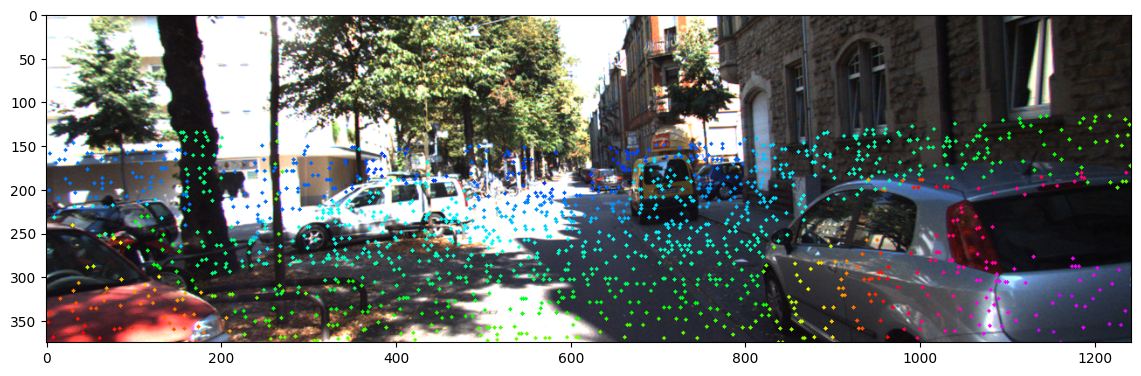

In [43]:
img_lidar = show_lidar_on_image(pc_velo[:, :3], img, calib, img_width, img_height)
img_lidar = cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB)

fig_lidar = plt.figure(figsize=(14, 7))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.show()

In [ ]:
img_bbox2d, img_bbox3d = show_image_with_boxes(img, , calib)
img_bbox2d = cv2.cvtColor(img_bbox2d, cv2.COLOR_BGR2RGB)

fig_bbox2d = plt.figure(figsize=(14, 7))
ax_bbox2d = fig_bbox2d.subplots()
ax_bbox2d.imshow(img_bbox2d)
plt.show()

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.